In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mpl.rc('font',**{'family':'serif','serif':['serif']})
mpl.rc('text', usetex=True)
import fitsio as fio

import h5py

import copy

import xpipe.tools.catalogs as catalogs
import xpipe.paths as paths
import xpipe.xhandle.parbins as parbins
import xpipe.xhandle.xwrap as xwrap
import xpipe.tools.selector as selector
import xpipe.xhandle.shearops as shearops
import xpipe.xhandle.pzboost as pzboost
import xpipe.tools.y3_sompz as sompz
import xpipe.tools.mass as mass
import xpipe.tools.visual as visual


from importlib import reload
import pickle


import astropy.cosmology as cosmology
# this is just the default cosmology
cosmo = cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

# we make sure the correct config file is loaded here, it will let us automatically now what type of files 
# were / will be produced, and where they will be placed
paths.update_params("/home/moon/vargatn/DES/PROJECTS/xpipe/settings/params_y3lwb_meta.yml")

reading DEFAULTS from default_params.yml
updating params from: /home/moon/vargatn/DES/PROJECTS/xpipe/settings/params.yml
updating params from: /home/moon/vargatn/DES/PROJECTS/xpipe/settings/params_y3rm_meta.yml
updating params from: /home/moon/vargatn/DES/PROJECTS/xpipe/settings/params_y3lwb_meta.yml

***********************

running in full mode

***********************



# Testing Shear catalogs for sanity

In [5]:
main_file_path = "/e/ocean1/users/vargatn/DESY3/Y3_mastercat_03_31_20.h5"

In [6]:
main_file = h5py.File(main_file_path, mode = 'r')


In [7]:
main_file.keys()

<KeysViewHDF5 ['catalog', 'index', 'maps', 'masks', 'randoms', 'regions']>

In [15]:
main_file["index"].keys()

<KeysViewHDF5 ['coadd_object_id', 'gold', 'maglim', 'mask', 'metacal', 'redmagic', 'select', 'select_1m', 'select_1m_bin1', 'select_1m_bin2', 'select_1m_bin3', 'select_1m_bin4', 'select_1p', 'select_1p_bin1', 'select_1p_bin2', 'select_1p_bin3', 'select_1p_bin4', 'select_2m', 'select_2m_bin1', 'select_2m_bin2', 'select_2m_bin3', 'select_2m_bin4', 'select_2p', 'select_2p_bin1', 'select_2p_bin2', 'select_2p_bin3', 'select_2p_bin4', 'select_bin1', 'select_bin2', 'select_bin3', 'select_bin4']>

In [9]:

main_file_path = "/e/ocean1/users/vargatn/DESY3/Y3_mastercat___UNBLIND___final_v1.1_12_22_20.h5"
main_file = h5py.File(main_file_path, mode = 'r')
fname_root = "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/shearcat/"
fname_prefix = "y3_mcal_sompz_v3_unblind_test"

fmt = ['%d', '%d'] + 10 * ['%.6f']
sheared_names = ["unsheared", "_1p", "_1m", "_2p", "_2m"]
# sheared_names = ["unsheared", "sheared_1p", "sheared_1m", "sheared_2p", "sheared_2m"]
select_names = ["select", "select_1p", "select_1m", "select_2p", "select_2m"]
bin_names = ["bin1", "bin2", "bin3", "bin4"]

In [17]:
ii_1p = main_file["index/select_1p_bin1"][:]
ii_1m = main_file["index/select_1m_bin1"][:]

In [29]:
main_file["catalog/metacal/sheared_1p"].keys()

<KeysViewHDF5 ['T', 'T_err', 'covmat_0_1', 'covmat_1_1', 'covmat_2_2', 'e_1', 'e_2', 'flux_err_i', 'flux_err_r', 'flux_err_z', 'flux_i', 'flux_r', 'flux_z', 'size_ratio', 'snr', 'weight']>

In [33]:
_e_1p = main_file["catalog/metacal/unsheared/e_1"][:]
_e_1m = main_file["catalog/metacal/unsheared/e_1"][:]
e_1p = _e_1p[ii_1p]
e_1m = _e_1m[ii_1m]

In [34]:
(e_1p.mean() - e_1m.mean()) / 0.02

0.006800019798311726

# Testing output

In [50]:
oname = "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/lenscat/LWB_DESY3_ALL.fits"
allgal = fio.read(oname)

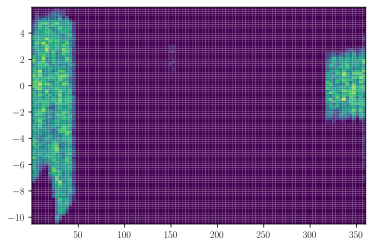

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist2d(allgal["RA"], allgal["DEC"], bins=100)

None

In [2]:
main_file_path = "/e/ocean1/users/vargatn/DESY3/Y3_mastercat_03_31_20.h5"
src = sompz.sompz_reader(main_file_path)
src.build_lookup()

In [3]:
flist, flist_jk, rlist, rlist_jk = parbins.get_file_lists(paths.params, paths.dirpaths)

In [4]:
i = 0
fname = flist[i]
rname = rlist[i]

In [10]:
ACP = shearops.AutoCalibrateProfile([fname,], flist_jk[i], src, xlims=(0.01, 100), sbins=(1, 2, 3))
ACP.get_profiles(ismeta=True, id_key="ID", z_key="Z")

loading source bin 1
loading source bin 2
loading source bin 3
/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v04/lwb-y3-lowz+cmass_v04_lens_qbin-0.fits


In [15]:
# This is a hotfix for the catalog matching bug... only need to be run once if you encounter obviously incorrect sigma crits with random points
fname = "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v04/lwb-y3-lowz+cmass_v04_lens_qbin-"+str(i)+".fits"
tmp = fio.read(fname)
tmp["ID"] = tmp["index"]
fio.write(fname, tmp, clobber=True)    

In [17]:
ACP_rand = shearops.AutoCalibrateProfile([rname,], rlist_jk[i], src, xlims=(0.01, 100), sbins=(1, 2, 3))
ACP_rand.get_profiles(ismeta=False, id_key="ID", z_key="Z")

loading source bin 1
loading source bin 2
loading source bin 3
/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v04/lwb-y3-lowz+cmass_v04_rand_qbin-0.fits


In [26]:
ACP_rand._profiles[0].dst_sub.shape

(15, 100)

In [34]:
arr = ACP_rand._profiles[0].dst_sub.mean(axis=1)


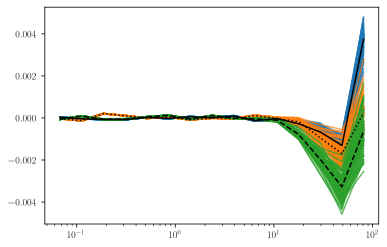

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in np.arange(100):
    arr = ACP_rand._profiles[0].dst_sub[:, i]
    ax.plot(ACP_rand.rr, ACP_rand.rr * arr, color="C0", alpha=0.7)
    
for i in np.arange(100):
    arr = ACP_rand._profiles[1].dst_sub[:, i]
    ax.plot(ACP_rand.rr, ACP_rand.rr * arr, color="C1", alpha=0.7)
    
for i in np.arange(100):
    arr = ACP_rand._profiles[2].dst_sub[:, i]
    ax.plot(ACP_rand.rr, ACP_rand.rr * arr, color="C2", alpha=0.7)    
    

arr = ACP_rand._profiles[0].dst_sub.mean(axis=1)
ax.plot(ACP_rand.rr, ACP_rand.rr * arr, color="black")      
arr = ACP_rand._profiles[1].dst_sub.mean(axis=1)
ax.plot(ACP_rand.rr, ACP_rand.rr * arr, color="black", ls=":")      
arr = ACP_rand._profiles[2].dst_sub.mean(axis=1)
ax.plot(ACP_rand.rr, ACP_rand.rr * arr, color="black", ls="--")       
    
ax.set_xscale("log")

In [40]:
prof = ACP_rand._profiles[2]

In [48]:
prof.dst_sub.max(axis=1)

array([-5.75780256e-04,  1.02264113e-03, -1.81546762e-04, -7.85551007e-05,
        1.39872216e-04,  1.69688590e-04, -2.08778682e-05,  5.65417622e-05,
        7.04000680e-06,  1.36745530e-06, -1.77674354e-06, -2.44957765e-05,
       -3.99566763e-05, -3.61436133e-05,  2.09765144e-05])

In [ ]:
data[self.dst_nom, ind][:, cind]

array([-8.53409742e-04,  7.92293875e-04, -3.70594287e-04, -1.75071986e-04,
        9.09235001e-05,  1.47334024e-04, -3.68065797e-05,  4.69959100e-05,
       -4.82652667e-07, -7.40052506e-06, -9.90730698e-06, -4.39757601e-05,
       -6.67809435e-05, -6.69088598e-05, -7.93965244e-06])

In [ ]:
dst_sub[cind, lab] = dsum_jack / (dsum_w_jack

In [59]:
arr

array([-8.53409742e-04,  7.92293875e-04, -3.70594287e-04, -1.75071986e-04,
        9.09235001e-05,  1.47334024e-04, -3.68065797e-05,  4.69959100e-05,
       -4.82652667e-07, -7.40052506e-06, -9.90730698e-06, -4.39757601e-05,
       -6.67809435e-05, -6.69088598e-05, -7.93965244e-06])

No handles with labels found to put in legend.


Text(0, 0.5, '$\\Delta\\Sigma$ [$M_\\odot  / pc^2$]')

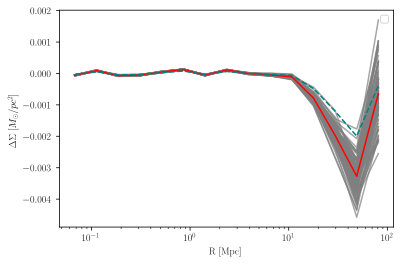

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in np.arange(100):
    arr = ACP_rand._profiles[2].dst_sub[:, i]
    ax.plot(ACP_rand.rr, ACP_rand.rr * arr, color="gray", alpha=0.7)
# ax.errorbar(prof.rr, prof.rr * prof.dst, prof.rr * prof.dst_err, capsize=4)

arr = prof.data[4].sum(axis=0) / prof.data[8].sum(axis=0)
ax.plot(prof.rr, prof.rr * arr, color="red")

arr = prof.data[4].sum(axis=0) / prof.data[3].sum(axis=0)
ax.plot(prof.rr, prof.rr * arr, color="teal", ls="--")

ax.set_label("JK patches vs error bar")
ax.set_xscale("log")
ax.set_xlabel("R [Mpc]")
   
ax.legend()
ax.set_ylabel("$\Delta\Sigma$ [$M_\odot  / pc^2$]")

No handles with labels found to put in legend.


Text(0, 0.5, 'X-shear')

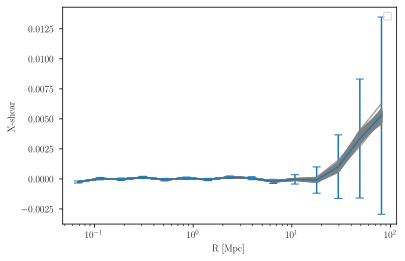

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in np.arange(100):
    arr = ACP_rand._profiles[2].dsx_sub[:, i]
    ax.plot(ACP_rand.rr, ACP_rand.rr * arr, color="gray", alpha=0.7)
ax.errorbar(prof.rr, prof.rr * prof.dsx, prof.rr * prof.dst_err, capsize=4)

ax.set_label("JK patches vs error bar")
ax.set_xscale("log")
ax.set_xlabel("R [Mpc]")
   
ax.legend()
ax.set_ylabel("X-shear")

In [23]:
ACP_rand._profiles[0].ds_sub

array([[ 5.80036848e-04,  4.85203996e-04,  6.86248601e-04, ...,
         3.03944349e-04,  4.79980294e-04,  4.32613226e-04],
       [-3.09641366e-04, -3.08641018e-04, -4.20400362e-04, ...,
        -4.11489367e-04, -3.58870403e-04, -4.42048337e-04],
       [-3.89323522e-04, -3.76768457e-04, -3.30848746e-04, ...,
        -4.08483889e-04, -3.68711918e-04, -3.67310445e-04],
       ...,
       [-3.32377317e-05, -2.68044080e-05, -1.48008114e-05, ...,
        -1.93229761e-05, -3.35562650e-05, -2.29172609e-05],
       [-4.05878439e-05, -2.68109918e-05, -2.19789352e-05, ...,
        -2.68168116e-05, -2.95046640e-05, -2.31911672e-05],
       [ 2.68067300e-05,  5.16749894e-05,  4.87602939e-05, ...,
         4.81880790e-05,  5.10187436e-05,  4.62905042e-05]])

Text(0, 0.5, '$\\Delta\\Sigma$ [$M_\\odot  / pc^2$]')

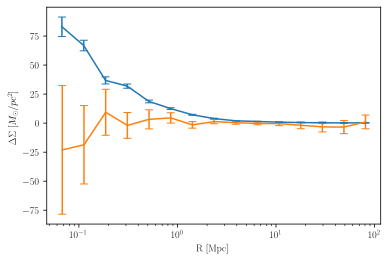

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.errorbar(ACP.rr, ACP.dst, ACP.dst_err, capsize=4)
ax.errorbar(ACP_rand.rr, ACP_rand.dst, ACP_rand.dst_err, capsize=4)

ax.set_xscale("log")
# ax.set_yscale("log")

ax.set_xlabel("R [Mpc]")
   
# ax.legend()
# ax.set_ylim(-20, 20)
    
ax.set_ylabel("$\Delta\Sigma$ [$M_\odot  / pc^2$]")

No handles with labels found to put in legend.


Text(0, 0.5, '$\\Delta\\Sigma$ [$M_\\odot  / pc^2$]')

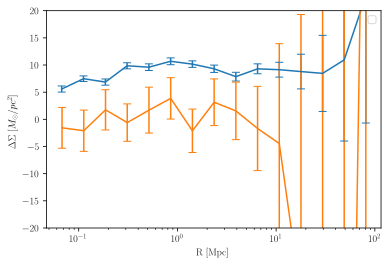

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.errorbar(ACP.rr, ACP.rr * ACP.dst, ACP.rr * ACP.dst_err, capsize=4)
ax.errorbar(ACP_rand.rr, ACP_rand.rr * ACP_rand.dst, ACP_rand.rr * ACP_rand.dst_err, capsize=4)

ax.set_xscale("log")
# ax.set_yscale("log")

ax.set_xlabel("R [Mpc]")
   
ax.legend()
ax.set_ylim(-20, 20)
    
ax.set_ylabel("$\Delta\Sigma$ [$M_\odot  / pc^2$]")

No handles with labels found to put in legend.


Text(0, 0.5, '$\\Delta\\Sigma$ [$M_\\odot  / pc^2$]')

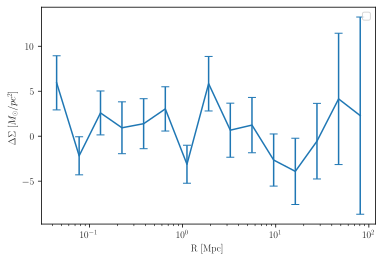

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)


ax.errorbar(ACP_rand_meta.rr, ACP_rand_meta.rr*ACP_rand_meta.dst, ACP_rand_meta.rr*ACP_rand_meta.dst_err, capsize=4)
# ax.errorbar(ACP_meta.rr, ACP_meta.dst, ACP_meta.dst_err, capsize=4)

ax.set_xscale("log")
# ax.set_yscale("log")

ax.set_xlabel("R [Mpc]")
   
ax.legend()
    
ax.set_ylabel("$\Delta\Sigma$ [$M_\odot  / pc^2$]")

No handles with labels found to put in legend.


Text(0, 0.5, '$\\Delta\\Sigma$ [$M_\\odot  / pc^2$]')

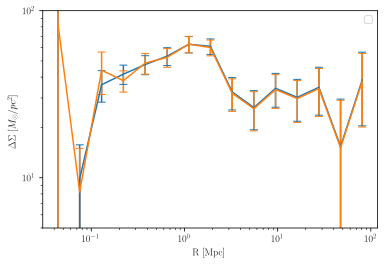

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)


ax.errorbar(ACP.rr, ACP.rr*ACP.dst, ACP.rr*ACP.dst_err, capsize=4)
ax.errorbar(ACP_meta.rr, ACP.rr*ACP_meta.dst, ACP.rr*ACP_meta.dst_err, capsize=4)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("R [Mpc]")
   
ax.legend()
ax.set_ylim(5, 100)
ax.set_ylabel("$\Delta\Sigma$ [$M_\odot  / pc^2$]")

In [59]:
ACP.dst

array([29.11379583, 45.85148911, 23.46908836, 38.92317208, 15.68818387,
       13.36110043,  4.23312078,  4.04529441,  2.89534452,  0.79066283,
        0.68465076,  0.52054005,  0.28952745])